In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../")
DATA_PATH = '../data/'

## Data

In [79]:
k = 1
sampled_data = pd.read_pickle(DATA_PATH + 'train_data.pkl').sample(frac=k, random_state=137)
# sample size

In [94]:
# scaling data
%load_ext autoreload
%autoreload 2
from data_pipeline import data_pipeline_all_labels as data_pipeline

pipeline = data_pipeline()
data = pipeline.fit_transform(sampled_data)
unused_features = ['index']
data = data.drop(unused_features, axis=1)
data = data.astype(np.float32)
data.info()

# split on train and test
from sklearn.model_selection import train_test_split
del data['has_MCParticle']
del data['is_true_seed']

train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)
label_names = [
    'is_downstream_reconstructible',
    'has_MCParticle_not_electron',
    'is_downstream_reconstructible_not_electron',
#     'is_true_seed'
]
x_train = train_set.drop(label_names, axis=1)
y_train = train_set[label_names].copy().astype(np.int32)

x_test = test_set.drop(label_names, axis=1)
y_test = test_set[label_names].copy().astype(np.int32)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1754766 entries, 1042314 to 3481
Data columns (total 20 columns):
has_MCParticle                                float32
is_downstream_reconstructible                 float32
has_MCParticle_not_electron                   float32
is_downstream_reconstructible_not_electron    float32
is_true_seed                                  float32
seed_chi2PerDoF                               float32
seed_p                                        float32
seed_pt                                       float32
seed_nLHCbIDs                                 float32
seed_nbIT                                     float32
seed_nLayers                                  float32
seed_x                                        float32
seed_y                                        float32
seed_tx                                       float32
seed_ty                                 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b589500b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4b585d0940>]], dtype=object)

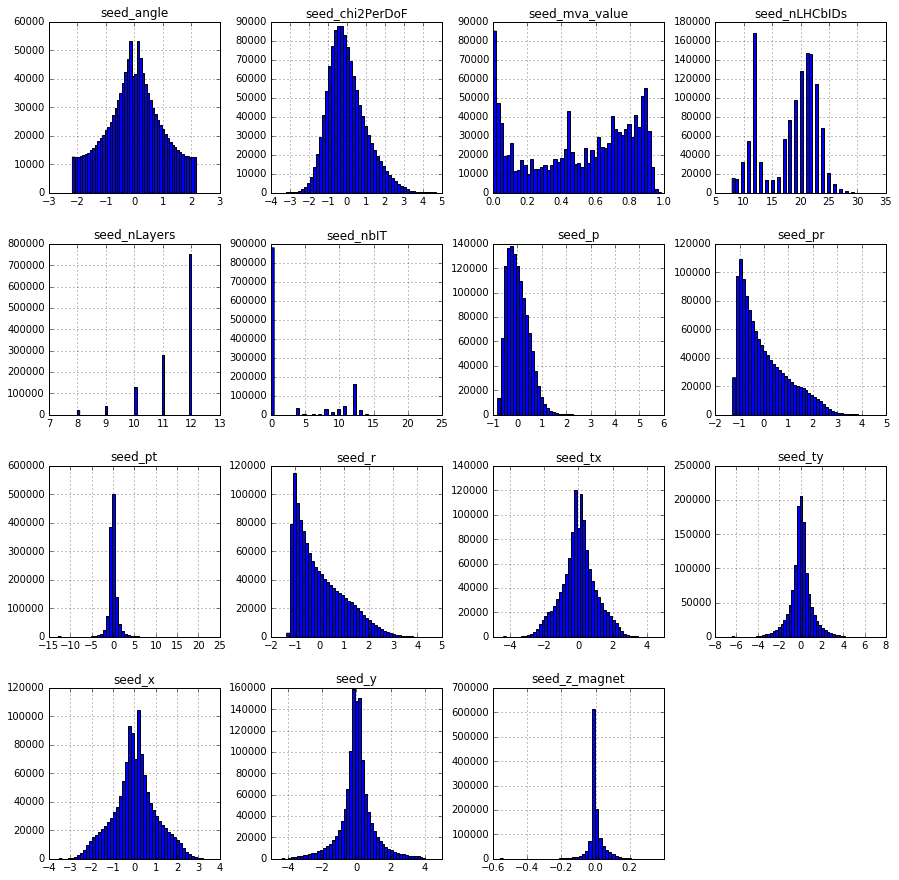

In [95]:
x_train.hist(bins=50, figsize=(15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b5c687518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4b5898ca58>]], dtype=object)

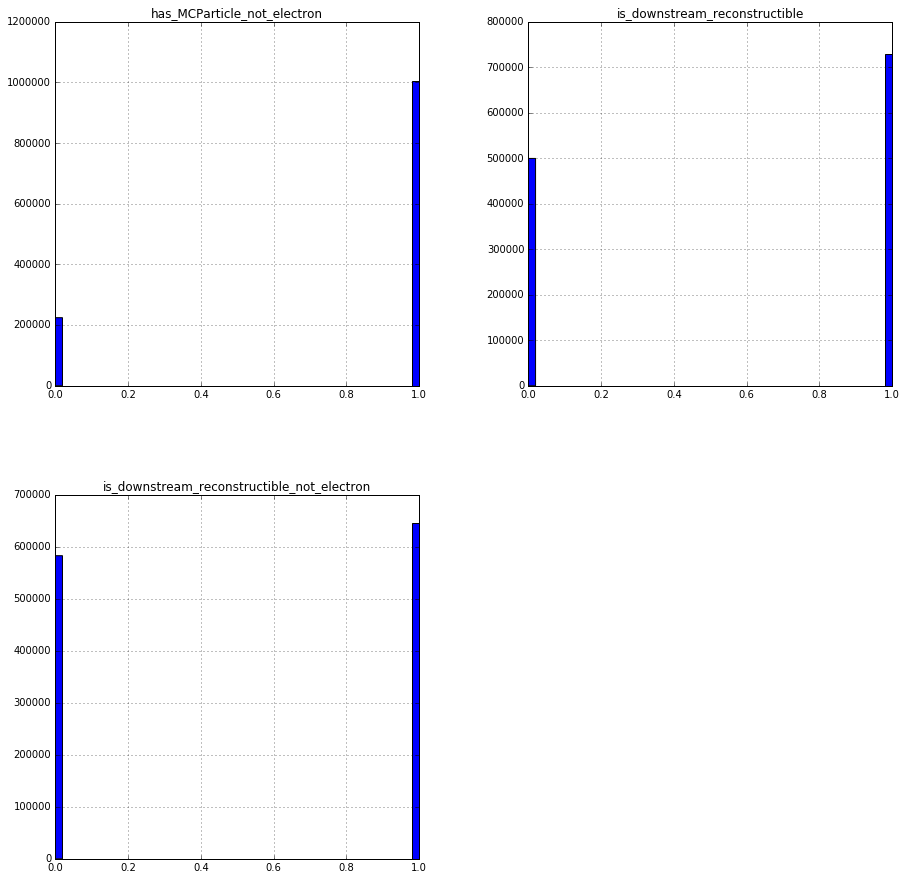

In [96]:
y_train.hist(bins=50, figsize=(15,15))

In [97]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1228336 entries, 385628 to 103571
Data columns (total 15 columns):
seed_chi2PerDoF    1228336 non-null float32
seed_p             1228336 non-null float32
seed_pt            1228336 non-null float32
seed_nLHCbIDs      1228336 non-null float32
seed_nbIT          1228336 non-null float32
seed_nLayers       1228336 non-null float32
seed_x             1228336 non-null float32
seed_y             1228336 non-null float32
seed_tx            1228336 non-null float32
seed_ty            1228336 non-null float32
seed_mva_value     1228336 non-null float32
seed_angle         1228336 non-null float32
seed_pr            1228336 non-null float32
seed_z_magnet      1228336 non-null float32
seed_r             1228336 non-null float32
dtypes: float32(15)
memory usage: 79.7 MB


In [98]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1228336 entries, 385628 to 103571
Data columns (total 3 columns):
is_downstream_reconstructible                 1228336 non-null int32
has_MCParticle_not_electron                   1228336 non-null int32
is_downstream_reconstructible_not_electron    1228336 non-null int32
dtypes: int32(3)
memory usage: 23.4 MB


## Model

In [99]:
from models import KerasDNN

In [107]:
def get_classes(x):
    return np.array(DNNclf.predict_proba(x) > np.float32(0.5), dtype=np.int32)

def per_class_accuracy(x, y):
    classes = get_classes(x)
    return np.mean( np.equal(classes,y), axis=0)
    

### training

In [111]:
from keras.callbacks import TensorBoard
DNNclf = KerasDNN(
    (x_train.shape[1],),
    (3,),
    neurons=100,
    layers=5,
    loss_metric='binary_crossentropy',
    metrics=['accuracy'],
    last_layer_act='sigmoid'
)
DNNclf.fit(
    x_train.values, y_train.values,
    epochs=10,
    validation_data=(x_test.values, y_test.values),
#     callbacks=[Tensorboard()]
)

Train on 1228336 samples, validate on 526430 samples
Epoch 1/10
1228336/1228336 [==============================] - 204s - loss: 0.4015 - acc: 0.8263 - val_loss: 0.3720 - val_acc: 0.8428
Epoch 2/10
1228336/1228336 [==============================] - 199s - loss: 0.3775 - acc: 0.8407 - val_loss: 0.3794 - val_acc: 0.8393
Epoch 3/10
1228336/1228336 [==============================] - 199s - loss: 0.3692 - acc: 0.8454 - val_loss: 0.3525 - val_acc: 0.8528
Epoch 4/10
1228336/1228336 [==============================] - 200s - loss: 0.3639 - acc: 0.8483 - val_loss: 0.3621 - val_acc: 0.8484
Epoch 5/10
1228336/1228336 [==============================] - 200s - loss: 0.3598 - acc: 0.8506 - val_loss: 0.3507 - val_acc: 0.8552
Epoch 6/10
1228336/1228336 [==============================] - 205s - loss: 0.3573 - acc: 0.8519 - val_loss: 0.3543 - val_acc: 0.8516
Epoch 7/10
1228336/1228336 [==============================] - 202s - loss: 0.3556 - acc: 0.8529 - val_loss: 0.3497 - val_acc: 0.8539
Epoch 8/10
12283

In [112]:
per_class_accuracy(x_train.values, y_train.values)

array([ 0.85715716,  0.85413763,  0.82202997])

In [108]:
per_class_accuracy(x_train.values, y_train.values)

array([ 0.87132837,  0.86283476,  0.83467471])

In [109]:
per_class_accuracy(x_test.values, y_test.values)

array([ 0.8714416 ,  0.86285926,  0.83468267])

In [13]:
# import time
# import os
# model_path = '../saved_models/keras_binary_clf_{}/'.format(time.ctime())

# os.mkdir(model_path)
# DNNclf.model.save(model_path + 'keras_model.h5')

In [44]:
# import tensorflow as tf
# import keras.backend as K
# def export_binary_clf_as_SavedModel(keras_model, export_dir):
#     K.set_learning_phase(0)
    
#     inputs = tf.placeholder(tf.float32, shape=keras_model.layers[0].output.shape)
#     predictions = keras_model(inputs)
#     scores = tf.nn.softmax(predictions)
#     classes = tf.argmax(predictions, axis=1)
    
    
#     classify_signature = tf.saved_model.signature_def_utils.predict_signature_def(
#         {'inputs': inputs}, {'classes': classes}
#     )

#     score_signature = tf.saved_model.signature_def_utils.predict_signature_def(
#         {'inputs': inputs}, {'scores': scores}
#     )
#     if tf.saved_model.signature_def_utils.is_valid_signature(classify_signature) and tf.saved_model.signature_def_utils.is_valid_signature(score_signature):

#         signature_def_map = {
#             "classify":
#                 classify_signature,
#             'predict_probability':
#                 score_signature
#         }

#     builder = tf.saved_model.builder.SavedModelBuilder(os.path.join(export_dir, 'saved_model'))

#     tag_constants = [tf.saved_model.tag_constants.SERVING]
    
#     builder.add_meta_graph_and_variables(
#             K.get_session(),
#             tag_constants,
#             signature_def_map=signature_def_map,
#             assets_collection=tf.get_collection(tf.GraphKeys.ASSET_FILEPATHS),
#         )
#     builder.save()


In [45]:
# export_binary_clf_as_SavedModel(DNNclf.model, model_path)

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'../saved_models/keras_binary_clf_Sat Oct 21 19:30:12 2017/saved_model/saved_model.pb'
